In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
data = pd.read_csv('spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [4]:
data.shape

(5171, 4)

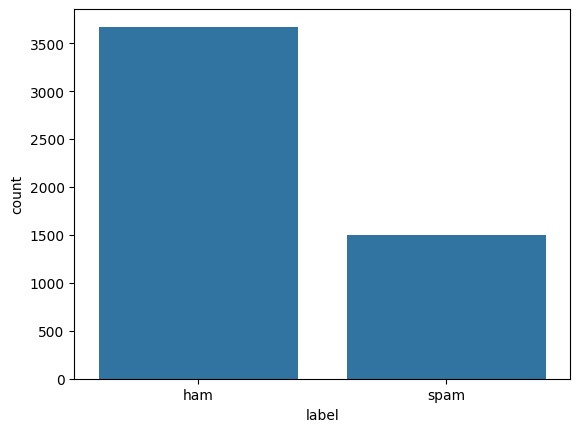

In [5]:
sns.countplot(x='label', data=data)
plt.show()

In [6]:
ham_msg=data[data["label"]=="ham"]
spam_msg=data[data["label"]=="spam"]
ham_balanced=ham_msg.sample(n=len(spam_msg),random_state=42)
balanced_data=pd.concat([spam_msg,ham_balanced]).reset_index(drop=True)


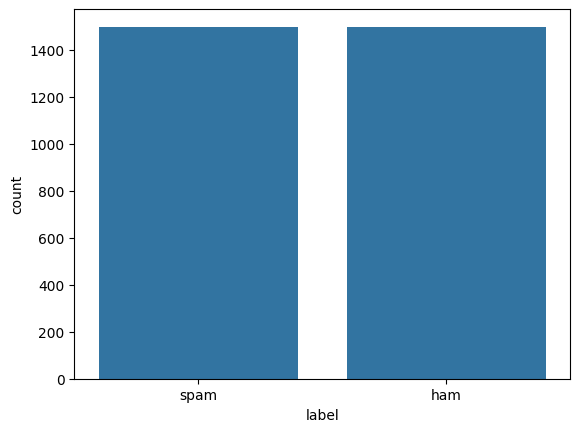

In [7]:
sns.countplot(x='label', data=balanced_data)
plt.show()

In [8]:
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
1,4185,spam,Subject: looking for medication ? we ` re the ...,1
2,4922,spam,Subject: vocable % rnd - word asceticism\r\nvc...,1
3,3799,spam,Subject: report 01405 !\r\nwffur attion brom e...,1
4,3948,spam,Subject: vic . odin n ^ ow\r\nberne hotbox car...,1


In [9]:
balanced_data["text"]=balanced_data["text"].str.replace("Subject","")

In [10]:
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,4685,spam,": photoshop , windows , office . cheap . main ...",1
1,4185,spam,: looking for medication ? we ` re the best so...,1
2,4922,spam,: vocable % rnd - word asceticism\r\nvcsc - br...,1
3,3799,spam,: report 01405 !\r\nwffur attion brom est inst...,1
4,3948,spam,: vic . odin n ^ ow\r\nberne hotbox carnal bri...,1


In [11]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,4685,spam,photoshop windows office cheap main trend...,1
1,4185,spam,looking for medication we re the best sourc...,1
2,4922,spam,vocable rnd word asceticism\r\nvcsc brand ...,1
3,3799,spam,report 01405 \r\nwffur attion brom est inst s...,1
4,3948,spam,vic odin n ow\r\nberne hotbox carnal bride ...,1


In [12]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,4685,spam,photoshop windows office cheap main trending a...,1
1,4185,spam,looking medication best source difficult make ...,1
2,4922,spam,vocable rnd word asceticism vcsc brand new sto...,1
3,3799,spam,report 01405 wffur attion brom est inst siupie...,1
4,3948,spam,vic odin n ow berne hotbox carnal bride cutwor...,1


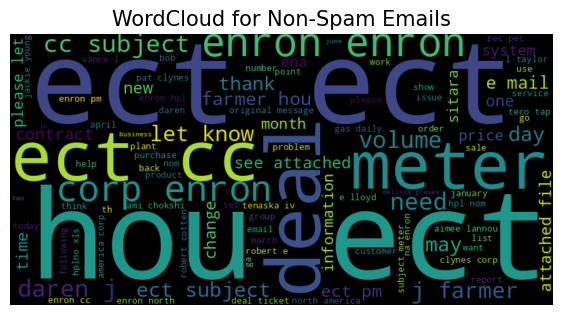

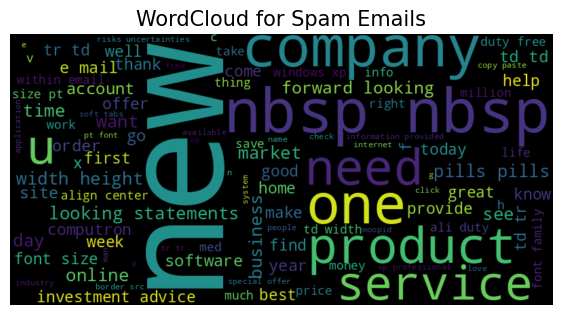

In [13]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

In [14]:
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100  # Maximum sequence length
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.5313 - loss: 0.6832 - val_accuracy: 0.8833 - val_loss: 0.4667 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9476 - loss: 0.2383 - val_accuracy: 0.9483 - val_loss: 0.2096 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9830 - loss: 0.0883 - val_accuracy: 0.9500 - val_loss: 0.2032 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9797 - loss: 0.0992 - val_accuracy: 0.9433 - val_loss: 0.2450 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9870 - loss: 0.0696 - val_accuracy: 0.9467 - val_loss: 0.2253 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9795 - loss: 0.0976 - val_accuracy: 0.9467 - val_loss: 0.2353 - learning_rate: 5.0000e-04


In [17]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9636 - loss: 0.1576
Test Loss : 0.20316439867019653
Test Accuracy : 0.949999988079071


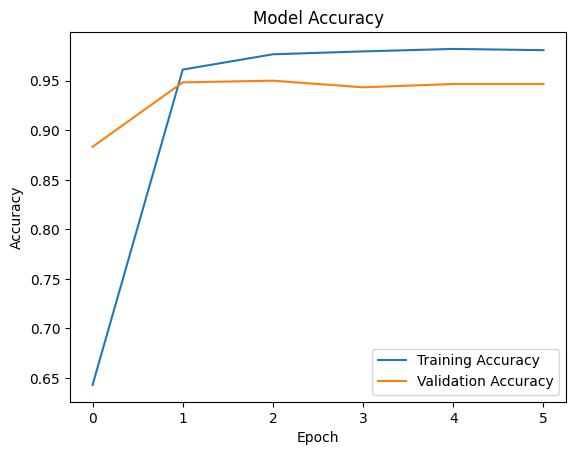

In [18]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [19]:
def preprocess_text(text):
    import string
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords and lowercase
    words = [word.lower() for word in text.split() if word.lower() not in stop_words]

    return " ".join(words)

def predict_email(text):
    # Preprocess like training data
    cleaned_text = preprocess_text(text)

    # Tokenize using the trained tokenizer
    seq = tokenizer.texts_to_sequences([cleaned_text])

    # Pad the sequence
    padded = pad_sequences(seq, maxlen=100, padding='post', truncating='post')

    # Predict
    pred = model.predict(padded)[0][0]

    # Return label and confidence
    label = "Spam" if pred > 0.5 else "Not Spam"
    print(f"Prediction: {label} (Confidence: {pred:.2f})")
    return label, pred


In [20]:
email = '''Hi Ayush kumar yadav,

Your certificate "Introduction to Data Science" is ready to be downloaded. You can download it from here.

Have a great day!

Thanks,
Your Wingspan Team'''
predict_email(email)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
Prediction: Spam (Confidence: 0.97)


('Spam', np.float32(0.97100616))

In [21]:
import gradio as gr
iface = gr.Interface(
    fn=predict_email,
    inputs=gr.Textbox(lines=5, placeholder="Enter your email text here..."),
    outputs="text",
    title="📧 Spam Email Classifier",
    description="This LSTM-based model detects whether an email is Spam or Not Spam."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c562f1352824933603.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [22]:
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 📧 Spam Email Classifier")
    gr.Markdown("This model detects whether an email is **Spam** or **Not Spam** using an LSTM network. Enter your email content below:")

    with gr.Row():
        email_input = gr.Textbox(lines=8, label="📨 Enter Email Text", placeholder="Type or paste your email here...")
        output_label = gr.Text(label="Prediction")

    with gr.Row():
        submit_btn = gr.Button("🔍 Check Email")
        clear_btn = gr.Button("🧹 Clear")

    submit_btn.click(fn=predict_email, inputs=email_input, outputs=output_label)
    clear_btn.click(fn=lambda: "", inputs=None, outputs=output_label)

    with gr.Row():
         prediction_text = gr.Text(label="Prediction")
         confidence = gr.Slider(minimum=0, maximum=1, step=0.01, label="Confidence Score")

    def predict_email_extended(text):
       cleaned_text = preprocess_text(text)
       seq = tokenizer.texts_to_sequences([cleaned_text])
       padded = pad_sequences(seq, maxlen=100, padding='post', truncating='post')
       pred = model.predict(padded)[0][0]
       label = "Spam" if pred > 0.5 else "Not Spam"
       return label, pred


demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://237d4c7748cb14c83c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
